# Main Modelling Notebook

David Modjeska and Andrew Greene

This notebook contains the actual models that we are using for this project.

In [3]:
# Begin with all the necessary imports

import itertools as it
import matplotlib
import matplotlib.cm as cmx
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import os.path as op
import pandas as pd
import re
import scipy as sp
import sklearn.preprocessing as Preprocessing
import datetime

from itertools import combinations
from sklearn.cross_validation import KFold as kfold
from sklearn.decomposition import TruncatedSVD as tSVD
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression as Lin_Reg
from sklearn.linear_model import LogisticRegression as Log_Reg
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier as DTC
from scipy.io import mmread

%matplotlib inline
plt.style.use('ggplot') 
from IPython.display import display, HTML

#### Load Data

The loading (which also handles filtering, standardizing, one-hot-encoding, etc.) occurs in a separate module for clarity's sake. Please see `Data_Loading.ipynb`, which is used to automatically generate `data_loading.py`

In [4]:
# load data
%run -i data_loading.py

248445
113036


C:\Users\agreene\AppData\Local\Continuum\Anaconda2\envs\amg1\lib\site-packages\numpy\lib\function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


Indexes computed

address_state object
annual_income float64
cpi float64
delinq_2_yrs int64
desc_len float64
dti float64
employ_length object
gdp float64
home_owner object
initial_list_status object
inquiry_6_mos int64
loan_amount int64
loan_purpose object
loan_term int64
months_since_last_record float64
open_accounts int64
revol_util float64
rir float64
total_accounts int64
unemploy float64
verif_status object
months_since_earliest_credit float64
emp_cleaned object
(Training set has 28182 rows)

address_state object
annual_income float64
cpi float64
delinq_2_yrs int64
desc_len float64
dti float64
employ_length object
gdp float64
home_owner object
initial_list_status object
inquiry_6_mos int64
loan_amount int64
loan_purpose object
loan_term int64
months_since_last_record float64
open_accounts int64
revol_util float64
rir float64
total_accounts int64
unemploy float64
verif_status object
months_since_earliest_credit float64
emp_cleaned object
(Test set has 84854 rows)
address_state objec

#### Set up Modelling Framework

Again, the framework is defined in an external module so it can be reused in various notebooks. Please see `Modelling_Framework.ipynb` from which `modelling_framework.py` is generated.

In [5]:
# set up modelling framework
% run -i modelling_framework.py

#### Sanity-checking the data

A reminder that initial data exploration occurs in the `amg_explore.ipynb` notebook. Here we are summarizing the properties of the data that have been loaded to establish benchmarks for our report.

In [6]:
# What is our sample size broken out by outcome?
y.value_counts()

True     23897
False     4285
Name: loan_status, dtype: int64

In [7]:
# As a result, what is our frequency of outcome?
y.mean()

0.84795259385423316

### Models without PCA

C:\Users\agreene\AppData\Local\Continuum\Anaconda2\envs\amg1\lib\site-packages\sklearn\metrics\classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


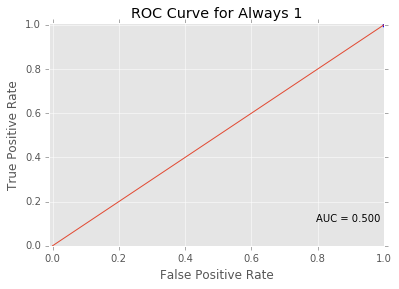

all   score: 0.848  baseline: 0.848   prec: nan   f1: 0.918  | test score 0.848  prec nan f1 0.000  GP -915MM
2011  score: 0.896  baseline: 0.896   prec: nan   f1: 0.945  | test score 0.893  prec nan
2012  score: 0.866  baseline: 0.866   prec: nan   f1: 0.928  | test score 0.865  prec nan
2013  score: 0.822  baseline: 0.822   prec: nan   f1: 0.902  | test score 0.824  prec nan


DummyClassifier(constant=1, random_state=None, strategy='constant')

In [8]:
# Simplest possible model: always assume the majority outcome. 
eval_model_by_year(lambda: DummyClassifier(strategy='constant', constant=1), model_name='Always 1')

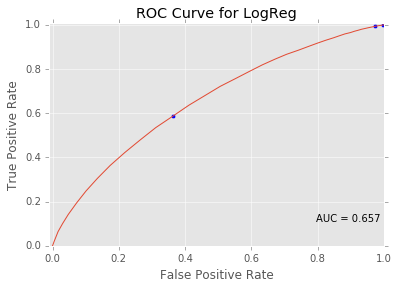

all   score: 0.848  baseline: 0.848   prec: 0.556   f1: 0.918  | test score 0.848  prec 0.564 f1 0.002  GP -913MM
2011  score: 0.894  baseline: 0.896   prec: nan   f1: 0.944  | test score 0.893  prec 0.600
2012  score: 0.866  baseline: 0.866   prec: nan   f1: 0.928  | test score 0.865  prec 0.800
2013  score: 0.822  baseline: 0.822   prec: 0.454   f1: 0.902  | test score 0.823  prec 0.585


In [9]:
# Simplest approach is a naive Logistic Regression model
_ = eval_model_by_year(lambda: Log_Reg(), model_name='LogReg')

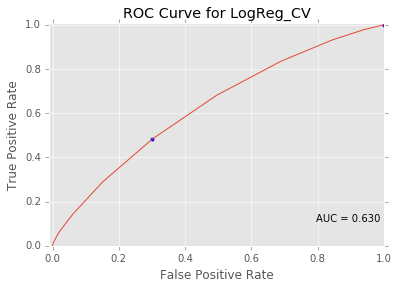

all   score: 0.848  baseline: 0.848   prec: nan   f1: 0.918  | test score 0.848  prec nan f1 0.000  GP -915MM
2011  score: 0.896  baseline: 0.896   prec: nan   f1: 0.945  | test score 0.893  prec nan
2012  score: 0.866  baseline: 0.866   prec: nan   f1: 0.928  | test score 0.865  prec nan
2013  score: 0.822  baseline: 0.822   prec: nan   f1: 0.902  | test score 0.824  prec 0.550
C= 0.0001


dti                                    -0.056826
revol_util                             -0.055701
annual_income                           0.047845
inquiry_6_mos                          -0.045184
cpi                                    -0.041426
gdp                                    -0.039468
rir                                    -0.029272
total_accounts                          0.028092
home_owner__MORTGAGE                    0.024625
home_owner__RENT                       -0.022464
months_since_earliest_credit            0.020701
delinq_2_yrs                           -0.016794
loan_purpose__credit_card               0.012470
open_accounts                          -0.011015
desc_len                                0.010777
employ_length__n/a                     -0.009203
employ_length__10                       0.008915
verif_status__Verified                 -0.007593
loan_amount                             0.007152
loan_purpose__other                    -0.006163
verif_status__Not_Ve

In [10]:
# But a more appropriate one uses cross-validation
logregcv_model = eval_model_by_year(lambda: Log_Reg_CV(), model_name='LogReg_CV')

# We want to know what value of C was selected by the cross-validation
print "C=", logregcv_model.C_[0]

# And we want to know which predictors are important; we do this by sorting them
# by the absolute value of their coefficients
lr_coeff = pd.DataFrame(logregcv_model.coef_.T, index=x_expanded.columns)
lr_coeff.columns = ['coeff']
lr_coeff['abs'] = lr_coeff.coeff.abs()
lr_coeff.sort_values('abs', ascending=False).coeff

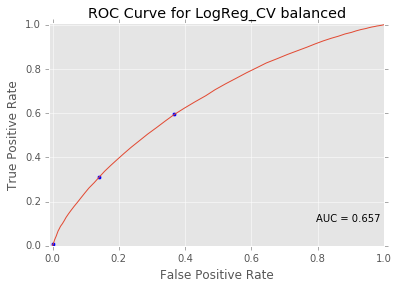

all   score: 0.607  baseline: 0.848   prec: 0.781   f1: 0.723  | test score 0.600  prec 0.782 f1 0.534  GP 13MM
2011  score: 0.624  baseline: 0.896   prec: 0.851   f1: 0.751  | test score 0.625  prec 0.845
2012  score: 0.596  baseline: 0.866   prec: 0.814   f1: 0.719  | test score 0.592  prec 0.823
2013  score: 0.619  baseline: 0.822   prec: 0.738   f1: 0.727  | test score 0.610  prec 0.749
C= 0.00599484250319


annual_income                           0.459223
loan_purpose__small_business           -0.343971
loan_purpose__credit_card               0.339828
employ_length__n/a                     -0.261436
revol_util                             -0.258278
emp_cleaned__                          -0.249169
inquiry_6_mos                          -0.197481
employ_length__1                        0.177445
cpi                                    -0.172602
loan_purpose__other                    -0.166542
loan_purpose__debt_consolidation        0.161694
address_state__CO                       0.152645
address_state__FL                      -0.149291
open_accounts                          -0.148040
home_owner__MORTGAGE                    0.144057
total_accounts                          0.142046
home_owner__RENT                       -0.131421
loan_purpose__major_purchase            0.128225
loan_purpose__moving                   -0.127842
dti                                    -0.125102
address_state__MA   

In [11]:
# But an even more appropriate one is (a) use cross-validation, and (b) use balanced weights
logregcv_model = eval_model_by_year(lambda: Log_Reg_CV(class_weight='balanced'), model_name='LogReg_CV balanced')

# We want to know what value of C was selected by the cross-validation
print "C=", logregcv_model.C_[0]

# And we want to know which predictors are important; we do this by sorting them
# by the absolute value of their coefficients
lr_coeff = pd.DataFrame(logregcv_model.coef_.T, index=x_expanded.columns)
lr_coeff.columns = ['coeff']
lr_coeff['abs'] = lr_coeff.coeff.abs()
lr_coeff.sort_values('abs', ascending=False).coeff

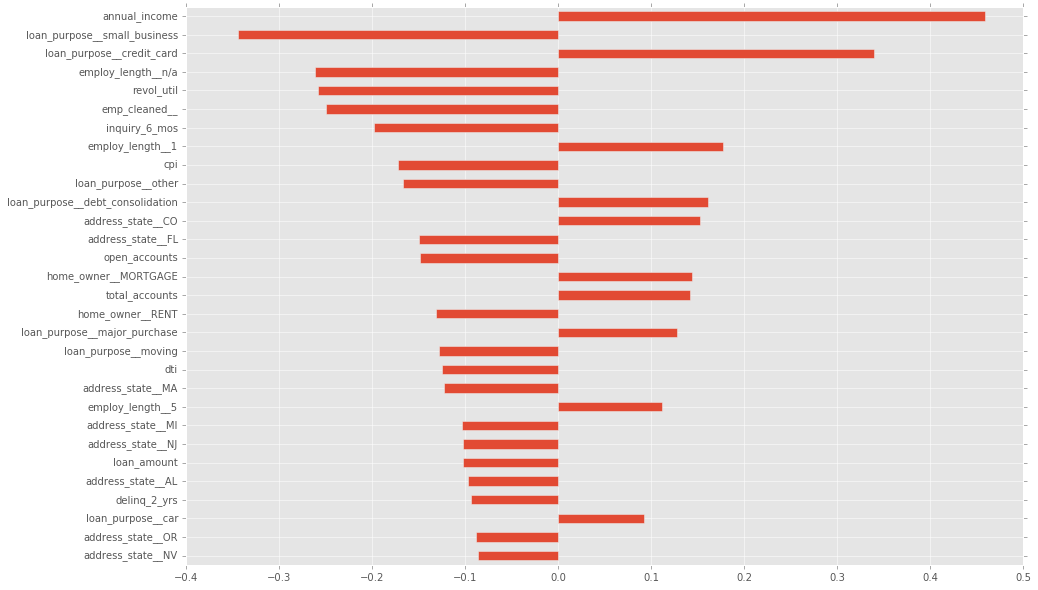

In [12]:
plt.figure(figsize=(15,10))
lr_coeff.sort_values('abs', ascending=False).coeff[0:30][::-1].plot(kind='barh')
plt.show()

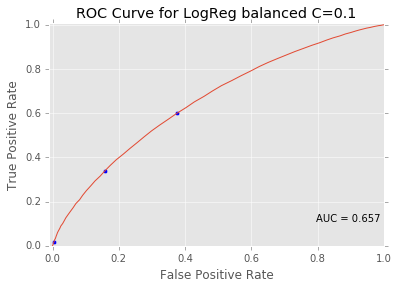

all   score: 0.605  baseline: 0.848   prec: 0.781   f1: 0.721  | test score 0.603  prec 0.782 f1 0.530  GP 5MM


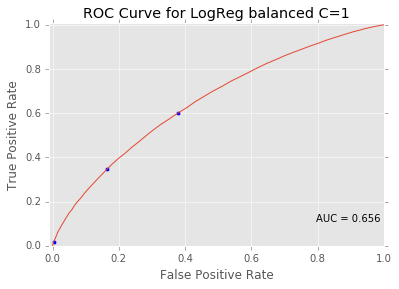

all   score: 0.607  baseline: 0.848   prec: 0.780   f1: 0.723  | test score 0.604  prec 0.782 f1 0.529  GP 3MM


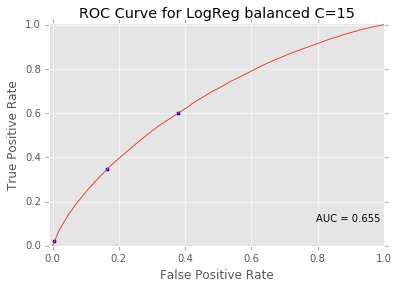

all   score: 0.607  baseline: 0.848   prec: 0.780   f1: 0.723  | test score 0.603  prec 0.782 f1 0.529  GP 3MM


In [13]:
for C in (0.1, 1, 15):
    eval_model_all_years(lambda: Log_Reg(class_weight='balanced', C=C), model_name='LogReg balanced C='+str(C))

Let's examine cross-terms

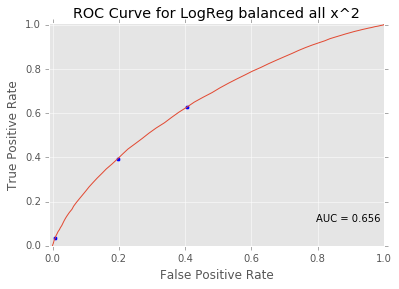

all   score: 0.627  baseline: 0.848   prec: 0.788   f1: 0.745  | test score 0.623  prec 0.778 f1 0.504  GP -65MM


In [14]:
lr_xterms = eval_model_all_years(lambda: Log_Reg_CV(class_weight='balanced'), 
                                 poly_degree = 2,
                                 # columns = ['loan_amount', 'installment', 'home_owner', 'loan_purpose', 'address_state'],
                                 model_name='LogReg balanced all x^2')

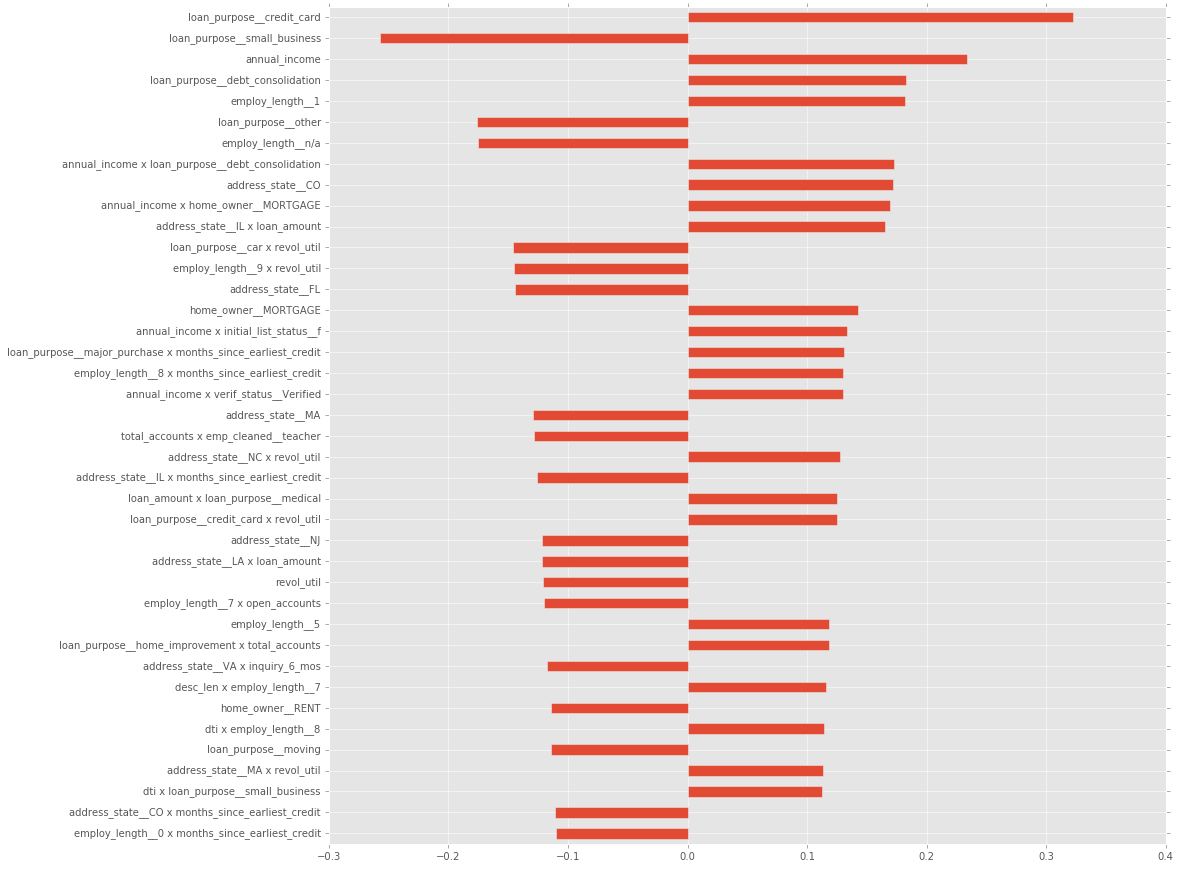

In [15]:
# And we want to know which predictors are important; we do this by sorting them
# by the absolute value of their coefficients
lr_coeff = pd.DataFrame(lr_xterms.coef_.T, index=cross_term_names(x_expanded, 2))
lr_coeff.columns = ['coeff']
lr_coeff['abs'] = lr_coeff.coeff.abs()
plt.figure(figsize=(15,15))
lr_coeff.sort_values('abs', ascending=False).coeff[0:40][::-1].plot(kind='barh')
plt.show()

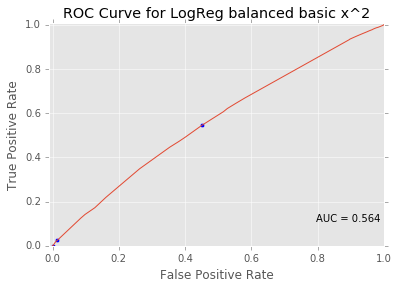

all   score: 0.545  baseline: 0.848   prec: 0.824   f1: 0.670  | test score 0.546  prec 0.822 f1 0.586  GP 45MM


LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [16]:
eval_model_all_years(lambda: Log_Reg(class_weight='balanced'), 
                     poly_degree = 2,
                     columns = ['loan_amount', 'installment', 'home_owner', 'loan_purpose'],
                     model_name='LogReg balanced basic x^2')

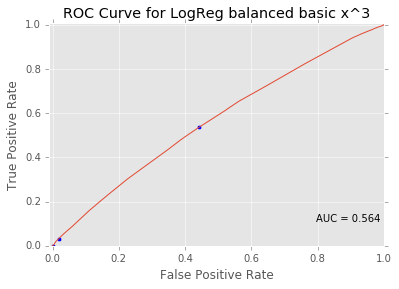

all   score: 0.535  baseline: 0.848   prec: 0.824   f1: 0.659  | test score 0.539  prec 0.823 f1 0.593  GP 31MM


LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [17]:
eval_model_all_years(lambda: Log_Reg(class_weight='balanced'), 
                     poly_degree = 3,
                     columns = ['loan_amount', 'installment', 'home_owner', 'loan_purpose'],
                     model_name='LogReg balanced basic x^3')

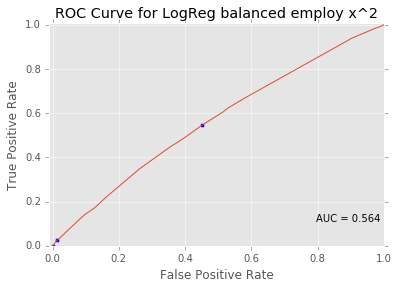

all   score: 0.545  baseline: 0.848   prec: 0.824   f1: 0.670  | test score 0.546  prec 0.822 f1 0.586  GP 45MM


LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [18]:
eval_model_all_years(lambda: Log_Reg(class_weight='balanced'), 
                     poly_degree = 2,
                     columns = ['loan_amount', 'installment', 'home_owner', 'loan_purpose', 'employ_title'],
                     model_name='LogReg balanced employ x^2')

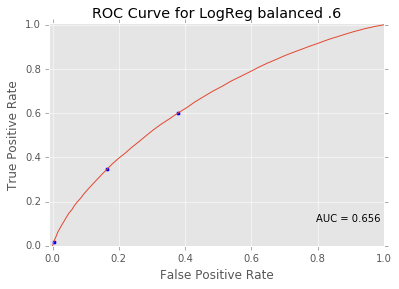

all   score: 0.607  baseline: 0.848   prec: 0.727   f1: 0.723  | test score 0.604  prec 0.734 f1 0.281  GP -493MM
2011  score: 0.628  baseline: 0.896   prec: 0.838   f1: 0.754  | test score 0.624  prec 0.816
2012  score: 0.595  baseline: 0.866   prec: 0.781   f1: 0.718  | test score 0.593  prec 0.802
2013  score: 0.617  baseline: 0.822   prec: 0.690   f1: 0.725  | test score 0.610  prec 0.702


LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [19]:
eval_model_by_year(lambda: Log_Reg(class_weight='balanced'), prob_threshold=.6, model_name='LogReg balanced .6')

C:\Users\agreene\AppData\Local\Continuum\Anaconda2\envs\amg1\lib\site-packages\sklearn\discriminant_analysis.py:688: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


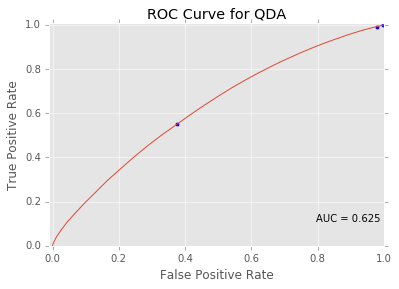

all   score: 0.848  baseline: 0.848   prec: 0.756   f1: 0.917  | test score 0.848  prec 0.747 f1 0.002  GP -913MM
2011  score: 0.896  baseline: 0.896   prec: nan   f1: 0.945  | test score 0.893  prec nan
2012  score: 0.866  baseline: 0.866   prec: nan   f1: 0.928  | test score 0.865  prec nan
2013  score: 0.820  baseline: 0.822   prec: 0.666   f1: 0.901  | test score 0.822  prec 0.703


QuadraticDiscriminantAnalysis(priors=None, reg_param=1,
               store_covariances=False, tol=0.0001)

In [20]:
eval_model_by_year(lambda: QDA(reg_param = 1), model_name='QDA')

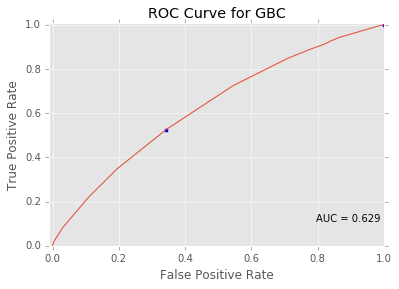

all   score: 0.848  baseline: 0.848   prec: nan   f1: 0.918  | test score 0.848  prec nan f1 0.000  GP -915MM
2011  score: 0.896  baseline: 0.896   prec: nan   f1: 0.945  | test score 0.892  prec 0.867
2012  score: 0.866  baseline: 0.866   prec: nan   f1: 0.928  | test score 0.865  prec nan
2013  score: 0.822  baseline: 0.822   prec: nan   f1: 0.902  | test score 0.824  prec nan


GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=2, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=10,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [21]:
eval_model_by_year(lambda: GBC(n_estimators = 10, max_depth = 2, learning_rate = 0.1), model_name='GBC')

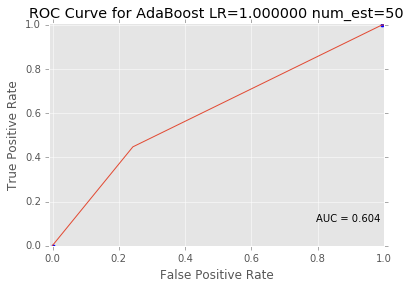

all   score: 0.847  baseline: 0.848   prec: 0.620   f1: 0.917  | test score 0.848  prec 0.539 f1 0.003  GP -912MM


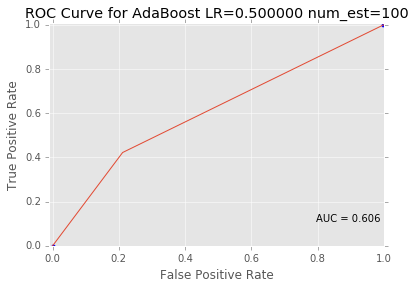

all   score: 0.848  baseline: 0.848   prec: nan   f1: 0.918  | test score 0.848  prec 0.600 f1 0.001  GP -914MM


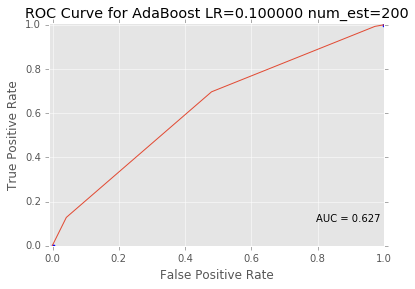

all   score: 0.848  baseline: 0.848   prec: nan   f1: 0.918  | test score 0.848  prec nan f1 0.000  GP -915MM


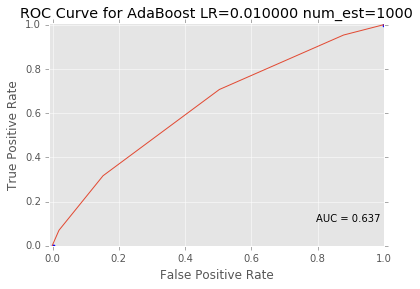

all   score: 0.848  baseline: 0.848   prec: nan   f1: 0.918  | test score 0.848  prec nan f1 0.000  GP -915MM


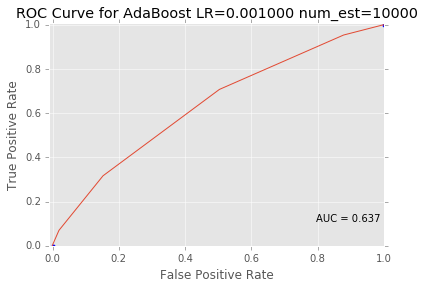

all   score: 0.848  baseline: 0.848   prec: nan   f1: 0.918  | test score 0.848  prec nan f1 0.000  GP -915MM


In [22]:
from sklearn.ensemble import AdaBoostClassifier
for num_est, l_rate in ((50, 1.0), (100, 0.5), (200, 0.1), (1000, 0.01), (10000, 0.001)):
    eval_model_all_years(lambda: AdaBoostClassifier(random_state=1729, n_estimators=num_est, learning_rate = l_rate),
                        model_name = 'AdaBoost LR=%f num_est=%d' % (l_rate, num_est,))

In [23]:
pd.DataFrame(model_performance).T.sort_values('test_prec', ascending=False)

,auc,baseline,f1,prec,score,test_f1,test_prec,test_profit,test_score
LogReg balanced basic x^3,0.564158,0.847953,0.659433,0.823989,0.535093,0.593443,0.822941,31.757548,0.539385
LogReg balanced basic x^2,0.563749,0.847953,0.670414,0.823727,0.545276,0.585755,0.822404,45.756872,0.545796
LogReg balanced employ x^2,0.563749,0.847953,0.670414,0.823727,0.545276,0.585755,0.822404,45.756872,0.545796
LogReg balanced C=15,0.655082,0.847953,0.722553,0.780111,0.606770,0.529294,0.782489,3.427875,0.603401
LogReg balanced C=1,0.655582,0.847953,0.722665,0.780103,0.606877,0.528969,0.782289,3.064922,0.603708
LogReg_CV balanced,0.656792,0.847953,0.722571,0.780541,0.606664,0.533929,0.781949,13.870466,0.600361
LogReg balanced C=0.1,0.656841,0.847953,0.720568,0.781220,0.604570,0.529524,0.781844,5.728478,0.603495
LogReg balanced all x^2,0.655560,0.847953,0.744838,0.787603,0.626641,0.503800,0.777974,-65.843792,0.622516
QDA,0.625398,0.847953,0.917445,0.755714,0.847527,0.001804,0.747126,-913.708314,0.847845
LogReg balanced .6,0.655582,0.847953,0.722665,0.726520,0.606877,0.281045,0.733955,-493.305109,0.603708


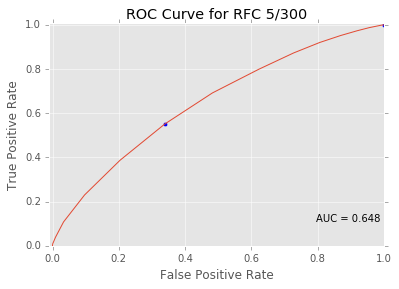

all   score: 0.848  baseline: 0.848   prec: nan   f1: 0.918  | test score 0.848  prec nan f1 0.000  GP -915MM
2011  score: 0.896  baseline: 0.896   prec: nan   f1: 0.945  | test score 0.893  prec nan
2012  score: 0.866  baseline: 0.866   prec: nan   f1: 0.928  | test score 0.865  prec nan
2013  score: 0.822  baseline: 0.822   prec: nan   f1: 0.902  | test score 0.824  prec nan


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=1,
            oob_score=False, random_state=1729, verbose=0,
            warm_start=False)

In [24]:
eval_model_by_year(lambda: RFC(random_state=1729, max_depth=5, n_estimators=300), model_name='RFC 5/300')

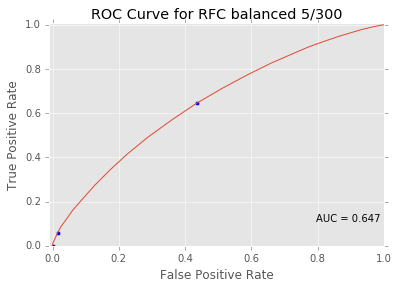

all   score: 0.633  baseline: 0.848   prec: 0.782   f1: 0.750  | test score 0.633  prec 0.778 f1 0.487  GP -168MM
2011  score: 0.744  baseline: 0.896   prec: 0.841   f1: 0.847  | test score 0.748  prec 0.825
2012  score: 0.639  baseline: 0.866   prec: 0.815   f1: 0.761  | test score 0.638  prec 0.819
2013  score: 0.643  baseline: 0.822   prec: 0.740   f1: 0.753  | test score 0.648  prec 0.739


RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=5, max_features='auto',
            max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=1,
            oob_score=False, random_state=1729, verbose=0,
            warm_start=False)

In [25]:
eval_model_by_year(lambda: RFC(random_state=1729, max_depth=5, class_weight = 'balanced', n_estimators=300),
                   model_name='RFC balanced 5/300')

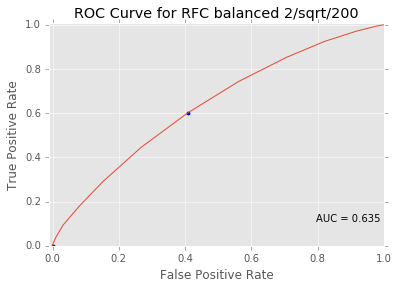

all   score: 0.600  baseline: 0.848   prec: 0.790   f1: 0.718  | test score 0.600  prec 0.790 f1 0.530  GP -50MM


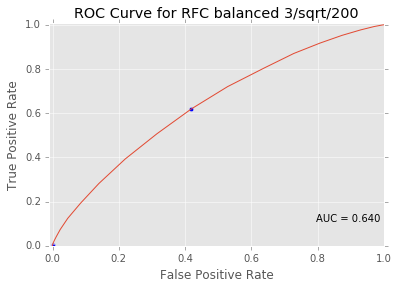

all   score: 0.615  baseline: 0.848   prec: 0.787   f1: 0.733  | test score 0.614  prec 0.786 f1 0.513  GP -99MM


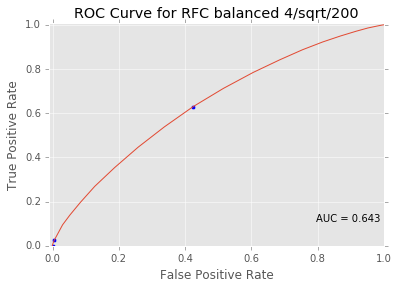

all   score: 0.620  baseline: 0.848   prec: 0.786   f1: 0.738  | test score 0.622  prec 0.782 f1 0.503  GP -128MM


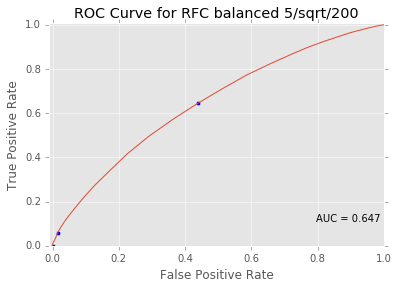

all   score: 0.632  baseline: 0.848   prec: 0.782   f1: 0.749  | test score 0.633  prec 0.779 f1 0.487  GP -163MM


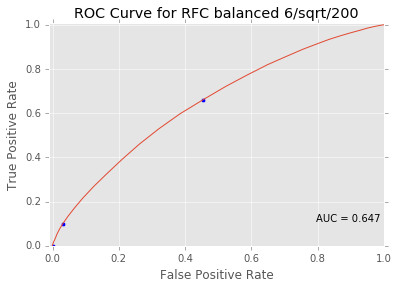

all   score: 0.645  baseline: 0.848   prec: 0.778   f1: 0.761  | test score 0.644  prec 0.776 f1 0.471  GP -198MM


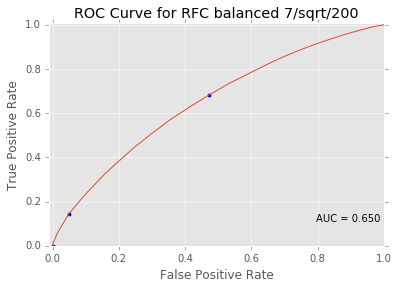

all   score: 0.661  baseline: 0.848   prec: 0.773   f1: 0.775  | test score 0.659  prec 0.771 f1 0.450  GP -240MM


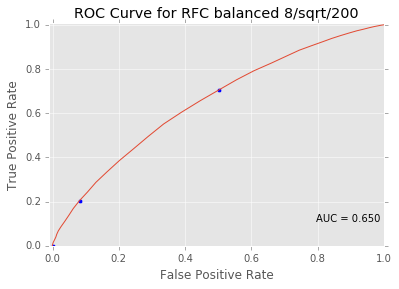

all   score: 0.677  baseline: 0.848   prec: 0.769   f1: 0.789  | test score 0.674  prec 0.768 f1 0.425  GP -297MM


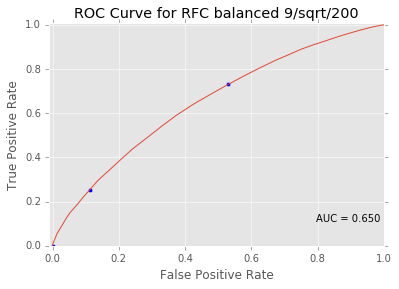

all   score: 0.698  baseline: 0.848   prec: 0.760   f1: 0.806  | test score 0.691  prec 0.762 f1 0.399  GP -345MM


In [ ]:
for max_depth in range(2, 10):
  for max_features in ['sqrt']: # + list(np.arange(0.1, 0.91, 0.5)):
    for class_weight in ('balanced',): # None
      eval_model_all_years(lambda: RFC(random_state=1729, 
                                     max_depth=max_depth, 
                                     max_features=max_features,
                                     class_weight = class_weight,
                                     n_estimators=200),
                         model_name='RFC ' + (class_weight or 'unbalanced') + 
                                 ' ' + str(max_depth) + '/' + str(max_features) + '/200')  # TODO: other hyperparams

In [ ]:
for max_depth in range(4, 10):
    for poly_degree in range(2, 5):
        eval_model_all_years(lambda: RFC(random_state=1729, 
                                     max_depth=max_depth, 
                                     class_weight = 'balanced',
                                     n_estimators=200),
                             x = cross_terms(x_expanded, poly_degree),
                             x_test = cross_terms(x_test_expanded, poly_degree),
                             model_name='RFC balanced ^' + str(poly_degree) + " to " 
                                 ' ' + str(max_depth) + '/200')

In [ ]:
eval_model_by_year(lambda: DTC(max_depth = 10, max_features = 'log2', class_weight = 'balanced', criterion = 'gini'),
                  model_name='DTC log2 balanced')

In [ ]:
eval_model_by_year(lambda: DTC(max_depth = 20, max_features = 'sqrt', class_weight = 'balanced', criterion = 'entropy'),
                  model_name='DTC sqrt balanced')

In [ ]:
eval_model_by_year(lambda: DTC(max_depth = 20, max_features = None, class_weight = 'balanced', criterion = 'entropy'),
                  model_name='DTC')

In [ ]:
# This takes a very long time but is the winner
eval_model_all_years(lambda: SVC(class_weight='balanced', probability=True))

In [ ]:
# This takes a very long time but is the winner
# Let's add in some different values for the hyperparam
for C in 10 ** np.arange(-2.0, 2.0, 0.5):
    print C, datetime.datetime.now()
    eval_model_all_years(lambda: SVC(class_weight='balanced', probability=True),
                        model_name="SVC " + str(C))
print "done", datetime.datetime.now()

In [ ]:
# This takes a very long time but is the winner
# Let's add in some different values for the hyperparam
for C in (100, ):
    print C, datetime.datetime.now()
    eval_model_all_years(lambda: SVC(class_weight='balanced', probability=True),
                        model_name="SVC " + str(C))
print "done", datetime.datetime.now()

#### Other Models without PCA

In [ ]:
# TODO: Try again, this time fitting a regression against the payments received

In [ ]:
# Curious -- what are the 95 CI for the baselines?
for yr in set(years.values):
    yr_n = (years == yr).sum()
    yr_def = (y[years == yr]).sum()
    yr_p = (y[years == yr]).mean()
    yr_se = (yr_p * (1.0-yr_p) / yr_n)
    print "y=%4d   n=%4d   d=%4d   p: %.3f | %.3f | %.3f" % (yr, yr_n, yr_def, yr_p - 1.96*yr_se, yr_p, yr_p + 1.96*yr_se)

In [ ]:
# Default rate for small business is higher, right?
print y.mean()
print y[x_expanded.loan_purpose__small_business == 1].mean()

In [ ]:
eval_model_by_year(lambda: Log_Reg(class_weight='balanced'), ['loan_purpose__small_business'], model_name='SmallBusiness')

In [ ]:
# LogReg is doing well.. what are the largest coefficients?
lr = Log_Reg(class_weight='balanced').fit(x_expanded[years.isin([2011,2012,2013])], y[years.isin([2011,2012,2013])])
lr_coeff = pd.DataFrame(lr.coef_.T, index=x_expanded.columns)
lr_coeff.columns = ['coeff']
lr_coeff['abs'] = lr_coeff.coeff.abs()

In [ ]:
lr_coeff.sort_values('abs', ascending=False).coeff

In [ ]:
lr_probs = lr.predict_proba(x_expanded)[:,0]

In [ ]:
plt.hist(lr_probs ,bins=40)
plt.show()

In [ ]:
1 - y.groupby([int(p*20)/20.0 for p in lr_probs]).mean()

In [ ]:
# probs = eval_model_with_threshold(lambda: Log_Reg())

In [ ]:
# probs = eval_model_with_threshold(lambda: Log_Reg(class_weight='balanced'))

In [ ]:
# VERY SLOW
#probs = eval_model_with_threshold(lambda: SVC(
#        random_state=1729,
#        probability=True))

#### Models with PCA

In [ ]:
eval_model_by_year(lambda: Log_Reg(), x = x_expanded_pca, x_test = x_test_expanded_pca)

In [ ]:
eval_model_by_year(lambda: Log_Reg(class_weight='balanced'), x = x_expanded_pca, x_test = x_test_expanded_pca)

In [ ]:
eval_model_by_year(lambda: Log_Reg(class_weight='balanced'), prob_threshold=.6, 
                   x = x_expanded_pca, x_test = x_test_expanded_pca)

In [ ]:
eval_model_by_year(lambda: QDA(), x = x_expanded_pca, x_test = x_test_expanded_pca)

In [ ]:
eval_model_by_year(lambda: GBC(n_estimators = 10, max_depth = 2, learning_rate = 0.1),
                  x = x_expanded_pca, x_test = x_test_expanded_pca)

## NLP Modeling

#### Top Terms in Each Class

In [ ]:
eval_model_by_year(lambda: Log_Reg(), x = count_cols_bool_train, x_test = count_cols_bool_test, 
                   y = y_nlp_train, y_test = y_nlp_test, years = years_nlp, years_test = years_nlp_test,
                  profit_data_test = x_nlp_test, model_name='NLP log_reg')

In [ ]:
eval_model_by_year(lambda: Log_Reg(C = 10 ** -6, class_weight = 'balanced'), 
                   x = count_cols_bool_train, x_test = count_cols_bool_test, 
                   y = y_nlp_train, y_test = y_nlp_test, years = years_nlp, years_test = years_nlp_test,
                  profit_data_test = x_nlp_test, model_name='NLP log_reg balanced')

In [ ]:
eval_model_by_year(lambda: Log_Reg(class_weight = 'balanced'), prob_threshold = 0.6,
                   x = count_cols_bool_train, x_test = count_cols_bool_test, 
                   y = y_nlp_train, y_test = y_nlp_test, years = years_nlp, years_test = years_nlp_test,
                  profit_data_test = x_nlp_test, model_name='NLP log_reg balanced proba6')

In [ ]:
eval_model_by_year(lambda: QDA(reg_param = 1), x = count_cols_bool_train, x_test = count_cols_bool_test, 
                   y = y_nlp_train, y_test = y_nlp_test, years = years_nlp, years_test = years_nlp_test,
                  profit_data_test = x_nlp_test, model_name='NLP QDA')

In [ ]:
eval_model_by_year(lambda: RFC(random_state=1729, max_depth=5, n_estimators=300),
                    x = count_cols_bool_train, x_test = count_cols_bool_test, 
                   y = y_nlp_train, y_test = y_nlp_test, years = years_nlp, years_test = years_nlp_test,
                  profit_data_test = x_nlp_test, model_name='RFC balanced')

In [ ]:
eval_model_by_year(lambda: RFC(random_state=1729, max_depth=5, n_estimators=300, class_weight = 'balanced'),
                    x = count_cols_bool_train, x_test = count_cols_bool_test, 
                   y = y_nlp_train, y_test = y_nlp_test, years = years_nlp, years_test = years_nlp_test,
                  profit_data_test = x_nlp_test, model_name='NLP RFC')

In [ ]:
eval_model_by_year(lambda: GBC(n_estimators = 10, max_depth = 2, learning_rate = 0.1),
                    x = count_cols_bool_train, x_test = count_cols_bool_test, 
                   y = y_nlp_train, y_test = y_nlp_test, years = years_nlp, years_test = years_nlp_test,
                  profit_data_test = x_nlp_test, model_name='GBC RFC')

#### Full Document-Term Matrix (Reduced with PCA)

In [ ]:
eval_model_by_year(lambda: Log_Reg(), x = desc_matrix_pca, x_test = desc_matrix_test_pca, 
                   y = y_nlp_train, y_test = y_nlp_test, years = years_nlp, years_test = years_nlp_test,
                   model_name='NLP PCA Log_Reg')

In [ ]:
eval_model_by_year(lambda: Log_Reg(class_weight = 'balanced'), x = desc_matrix_pca, x_test = desc_matrix_test_pca, 
                   y = y_nlp_train, y_test = y_nlp_test, years = years_nlp, years_test = years_nlp_test,
                   model_name='NLP PCA Log_Reg balanced')

In [ ]:
eval_model_by_year(lambda: GBC(n_estimators = 10, max_depth = 2, learning_rate = 0.1),
                   x = desc_matrix_pca, x_test = desc_matrix_test_pca,
                   y = y_nlp_train, y_test = y_nlp_test, years = years_nlp, years_test = years_nlp_test,
                   model_name='NLP PCA GBC')

## Stacking

In [ ]:
class Stacking(object):
    
    def __init__(self, unfitted_combiner, component_type = 'mixed'):
        self.combiner = unfitted_combiner
        self.model_stack = None   
        
        stack = []
        
        # logistic regression component models with various class weights
        if component_type == 'log_reg':
            for diff in np.arange(0, 5, 0.5):
                weight_dict = { 0 : 1, 1 : (1 + diff) }
                stack.append([Log_Reg(C = 1, class_weight = weight_dict), 'Log_Reg ' + str(1 + diff)])
                
        # default - mixed component models
        else:
            stack.append((Log_Reg(C = 10 ** -5), 'Log_Reg'))
            stack.append((Log_Reg(C = 10 ** -5, class_weight = 'balanced'), 'Log_Reg balanced'))
            stack.append((LDA(shrinkage = 1, solver = 'eigen'), 'LDA'))
            stack.append((QDA(reg_param = 1), 'QDA'))
            stack.append((RFC(random_state=1729, n_estimators = 10, max_depth = 4), 'RF'))
            stack.append((RFC(random_state=1729, n_estimators = 300, max_depth = 5, class_weight = 'balanced'),
                        'RF balanced'))
            stack.append((GBC(n_estimators = 10, max_depth = 2, learning_rate = 0.1), 'Boost'))
            stack.append((DTC(max_depth = 10, max_features = 'log2', criterion = 'gini'), 'Tree 1'))
            stack.append((DTC(max_depth = 20, max_features = 'sqrt', criterion = 'entropy'), 'Tree 2'))
            stack.append((DTC(max_depth = 20, max_features = None, criterion = 'entropy'), 'Tree 3'))
            stack.append((DTC(max_depth = 30, max_features = None, criterion = 'gini'), 'Tree 4'))      
            #stack.append(SVC(class_weight = 'balanced')) # slow
                         
        self.model_stack = pd.DataFrame(stack, columns = ['Model_Params', 'Model'])
        self.num_models = len(self.model_stack)
    
    def _predict_component_models(self, X):
        n = X.shape[0]
        y_hat_stack = np.zeros((n, self.num_models))
        for index in range(self.num_models):
            y_hat_stack[:, index] = self.model_stack.iloc[index, 0].predict(X)
        return y_hat_stack
        
    def fit(self, X, y):
        for index in range(self.num_models):
            self.model_stack.iloc[index, 0].fit(X, y)
        y_hat_stack = self._predict_component_models(X)
        self.combiner = self.combiner.fit(y_hat_stack, y)
        return self
        
    def score(self, X, y):
        y_hat_stack = self._predict_component_models(X)
        score = self.combiner.score(y_hat_stack, y)
        return score
              
    def predict(self, X):
        y_hat_stack = self._predict_component_models(X)
        y_hat = self.combiner.predict(y_hat_stack)
        return y_hat
    
    def predict_proba(self, X):
        y_hat_stack = self._predict_component_models(X)
        y_hat_proba = self.combiner.predict_proba(y_hat_stack)
        return y_hat_proba
    
    def confusion_matrix(self, y, y_hat):
        return confusion_matrix(y, y_hat)
     
    def f1_score(self, y, y_hat):
        return f1_score(y, y_hat, pos_label = 1)
    
    def get_features(self):
        long_name = str(type(self.combiner))
        short_name = re.sub('.*\.', '', long_name)
        short_name = re.sub('\'>', '', short_name)
        
        index = index = self.model_stack.iloc[:, 1]
        if short_name == 'LogisticRegression':
            return pd.DataFrame(self.combiner.coef_.T, index = index)
        else:
            return pd.DataFrame(self.combiner.feature_importances_.T, index = index)

In [ ]:
def print_stacking_features(x_train, y_train, x_test, y_test, combiner, component_type = 'mixed'):
    model = Stacking(combiner, component_type)
    model.fit(x_train, y_train)
    
    features = model.get_features()
    features.columns = ['Importance']
    features['Abs'] = np.abs(features.Importance)
    features = features.sort_values('Abs', ascending = False).drop('Abs', axis = 1)
    display(features)

#### Regular Data

In [ ]:
combiner = Log_Reg(C = 1, class_weight = 'balanced', penalty = 'l2', solver = 'liblinear')
eval_model_by_year(lambda: Stacking(combiner), model_name = "Stack LogReg balanced (mixed)")

In [ ]:
combiner = Log_Reg(C = 1, class_weight = 'balanced', penalty = 'l2', solver = 'liblinear')
eval_model_by_year(lambda: Stacking(combiner, 'log_reg'), model_name = "Stack LogReg balanced (logreg)")

In [ ]:
combiner = RFC(random_state=1729, n_estimators = 10, max_depth = 4, max_features = 'sqrt', 
               criterion = 'gini', class_weight = 'balanced')
eval_model_by_year(lambda: Stacking(combiner), model_name = "Stack RF balanced (mixed)")

In [ ]:
combiner = RFC(random_state=1729, n_estimators = 10, max_depth = 4, max_features = 'sqrt', 
               criterion = 'gini', class_weight = 'balanced')
eval_model_by_year(lambda: Stacking(combiner, 'log_reg'), model_name = "Stack RF balanced (logreg)")

In [ ]:
combiner = DTC(max_depth = 10, max_features = 'log2', class_weight = 'balanced', 
                           criterion = 'gini')
eval_model_by_year(lambda: Stacking(combiner), model_name = "Stack Tree balanced (mixed)")

In [ ]:
combiner = DTC(max_depth = 10, max_features = 'log2', class_weight = 'balanced', 
                           criterion = 'gini')
eval_model_by_year(lambda: Stacking(combiner, 'log_reg'), model_name = "Stack Tree balanced (logreg)")

#### Stacking Feature Importances

In [ ]:
combiner = Log_Reg(C = 1, class_weight = 'balanced', penalty = 'l2', solver = 'liblinear')
print_stacking_features(x_expanded, y, x_test_expanded, y_test, combiner, 'mixed')

In [ ]:
combiner = RFC(random_state=1729, n_estimators = 10, max_depth = 4, max_features = 'sqrt', 
               criterion = 'gini', class_weight = 'balanced')
print_stacking_features(x_expanded, y, x_test_expanded, y_test, combiner, 'mixed')

In [ ]:
combiner = DTC(max_depth = 10, max_features = 'log2', class_weight = 'balanced', 
                           criterion = 'gini')
print_stacking_features(x_expanded, y, x_test_expanded, y_test, combiner, 'mixed')

## Visualizations

In [ ]:
pd.DataFrame(model_performance).T.sort_values('test_prec', ascending=False)

In [ ]:
model_performance_df = pd.DataFrame(model_performance).T
for col in model_performance_df.columns:
    model_performance_df[col].sort_values().plot(kind='barh')
    plt.title(col)
    plt.show()

### Profit

In [ ]:
# calculate profits
revenues = profit_data_train.total_rec_int + profit_data_train.total_rec_prncp + \
        profit_data_train.total_rec_late_fee + profit_data_train.recoveries
costs = profit_data_train.loan_amount
profit_data_train.actual_profit = revenues - costs

In [ ]:
profit_ratio = np.where(y, 1.0, revenues / (profit_data_train.installment * 36))
plt.hist(profit_ratio, bins=40)

In [ ]:
from sklearn.linear_model import RidgeCV
np.random.seed(1729)
train_flags_ridge = np.random.random(len(x_expanded)) < 0.7

ridge_profit = RidgeCV().fit(x_expanded.iloc[train_flags_ridge, :], profit_ratio[train_flags_ridge])
print "Alpha:", ridge_profit.alpha_
print "Train R^2:", ridge_profit.score(x_expanded.iloc[train_flags_ridge, :], profit_ratio[train_flags_ridge])
print "Test R^2:", ridge_profit.score(x_expanded.iloc[~train_flags_ridge, :], profit_ratio[~train_flags_ridge])

In [ ]:
# print summary revenue and cost
print "REVENUES"
print "Total interested received =", profit_data.total_rec_int.sum() / float(10 ** 6)
print "Total principal received =", profit_data.total_rec_prncp.sum() / float(10 ** 6)
print "Total late fees received =", profit_data.total_rec_late_fee.sum() / float(10 ** 6)
print "Recoveries =", profit_data.recoveries.sum() / float(10 ** 6)
print
print "COSTS"
print "Total loan amounts =", profit_data.loan_amount.sum() / float(10 ** 6)

In [ ]:
### fit and score for profits

predictors = x_expanded_pca
response = profit_data_train.actual_profit > 0

np.random.seed(1729)
train_flags = np.random.random(predictors.shape[0]) < 0.7
local_x_train = predictors.iloc[train_flags, :]
local_y_train = response[train_flags]
local_x_test = predictors.iloc[~train_flags, :]
local_y_test = response[~train_flags]

model = Lin_Reg().fit(local_x_train, local_y_train)
local_test_score = model.score(local_x_test, local_y_test)
print "R-squared on local test set =", local_test_score

In [ ]:
### fit and score for classification

predictors = x_expanded_pca
response = profit_data_train.actual_profit > 0

np.random.seed(1729)
train_flags = np.random.random(predictors.shape[0]) < 0.7
local_x_train = predictors.iloc[train_flags, :]
local_y_train = response[train_flags]
local_x_test = predictors.iloc[~train_flags, :]
local_y_test = response[~train_flags]

model = Log_Reg(class_weight = 'balanced').fit(local_x_train, local_y_train)
local_test_score = model.score(local_x_test, local_y_test)
print "Accuracy on local test set =", local_test_score
local_test_y_hat = model.predict(local_x_test)
local_test_precision = local_y_test[local_test_y_hat].mean()
print "Precision on local test set =", local_test_precision

In [ ]:
### fit and predict for classification

model2 = Log_Reg(class_weight = 'balanced').fit(x_expanded_pca, y)
y_predict_train = pd.DataFrame(model2.predict(x_expanded_pca))
y_predict_test = pd.DataFrame(model2.predict(x_test_expanded_pca))

y_predict_train.index = x_expanded_pca.index
y_predict_test.index = x_test_expanded_pca.index

In [ ]:
eval_model_by_year(lambda: Log_Reg(class_weight = 'balanced'), x = y_predict_train, x_test = y_predict_test)

In [ ]:
eval_model_by_year(lambda: RFC(class_weight = 'balanced'), x = y_predict_train, x_test = y_predict_test)

# Regression modeling for payback ratio

In [ ]:
returns = data_filtered[['loan_status', 'loan_amount', 'installment',
                         'total_rec_int', 'total_rec_prncp', 'total_rec_late_fee', 
                     ]]
returns['expected_payment'] = returns.installment * 36
returns['total_paid'] = returns.total_rec_int + returns.total_rec_late_fee + returns.total_rec_prncp
returns['ratio'] = np.where(returns.loan_status,
                            1.0,
                            returns['total_paid'] / returns['expected_payment'])
# Plot distribution
returns.groupby(returns.loan_status).ratio.hist(bins=40)
plt.title("Using Time Value")
plt.show()

In [ ]:
returns_train = returns.ratio[sample_flags]
returns_test = returns.ratio[~sample_flags]

In [ ]:
linear_returns_model = RidgeCV().fit(x_expanded, returns_train)
print linear_returns_model.score(x_test_expanded, returns_test)

In [ ]:
lin_predict = linear_returns_model.predict(x_test_expanded)
for p in np.arange(0.7, 1.2, 0.1):
    yhat_lin = lin_predict >= p
    print p, ';  F1=', f1_score(y_test, yhat_lin, pos_label=1), ';  prec=',y_test[yhat_lin].mean()
    print confusion_matrix(y_test, yhat_lin)

In [ ]:
class PredictWrapper():
    def __init__(self, m):
        self.m = m
    def predict_proba(self, X):
        p = self.m.predict(X)
        return np.hstack((p, (1-p))).reshape(len(p), 2)

In [ ]:
ROC_plot(PredictWrapper(linear_returns_model), x_test_expanded, y_test, "Linear Model")

In [ ]:
linear_returns_model = RidgeCV().fit(cross_terms(x_expanded, 3), returns_train)
print linear_returns_model.score(cross_terms(x_test_expanded, 3), returns_test)

In [ ]:
from sklearn.linear_model import LassoCV
np.random.seed(1729)
linear_returns_model = LassoCV().fit(cross_terms(x_expanded, 3), returns_train)
print linear_returns_model.score(cross_terms(x_test_expanded, 3), returns_test)

In [ ]:
linear_returns_model = Lin_Reg().fit(x_expanded, returns_train)
print linear_returns_model.score(x_test_expanded, returns_test)

In [ ]:
for p in range(2,10):
    linear_returns_model = RidgeCV().fit(cross_terms(x_expanded, p), returns_train)
    print p, linear_returns_model.score(cross_terms(x_test_expanded, p), returns_test)

## Just for comparison, how does loan_subgrade do?

In [ ]:
x_with_subgrade = x_expanded.copy()
x_with_subgrade['subgrade'] = data_filtered.loan_subgrade[x_with_subgrade.index]
x_with_subgrade_test = x_test_expanded.copy()
x_with_subgrade_test['subgrade'] = data_filtered.loan_subgrade[x_with_subgrade_test.index]

In [ ]:
# Compare log reg cv balanced with subgrade as an available predictor
logregcv_model_with_subgrade = eval_model_all_years(lambda: Log_Reg_CV(class_weight='balanced'), 
                                                    model_name='LogReg_CV balanced w/subgrade',
                                                    x = x_with_subgrade,
                                                    x_test = x_with_subgrade_test
                                                 )

# We want to know what value of C was selected by the cross-validation
print "C=", logregcv_model_with_subgrade.C_[0]

In [ ]:
# And we want to know which predictors are important; we do this by sorting them
# by the absolute value of their coefficients
lr_coeff = pd.DataFrame(logregcv_model_with_subgrade.coef_.T, index=x_with_subgrade.columns)
lr_coeff.columns = ['coeff']
lr_coeff['abs'] = lr_coeff.coeff.abs()
plt.figure(figsize=(15,15))
lr_coeff.sort_values('abs', ascending=False).coeff[0:40][::-1].plot(kind='barh')
plt.show()
lr_coeff.sort_values('abs', ascending=False).coeff